In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts/

/content/gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts


In [3]:
!pip install segment_anything

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import glob
import os
import copy
import sys
from segment_anything import sam_model_registry
sys.path.append('../src')
from datasets import KneeSegDataset3D
from model_UNet import UNet3D
from model_SAM import my_SAM
from utils import sam_slice_transform

In [5]:
def show_mask_slices(img):
    num_subplots = 5
    plt.subplots(num_subplots, num_subplots, figsize = (num_subplots*4, num_subplots*4))

    for cnt, slnum in enumerate(range(0,img.shape[-1],img.shape[-1]//num_subplots**2)):

        if cnt < num_subplots**2:

            plt.subplot(num_subplots, num_subplots, cnt+1)
            plt.imshow(img[...,slnum], cmap = 'gray')
            plt.title('Slice {}'.format(slnum), fontsize= 20)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# FUNCTION FOR GIVING SAM A 3D IMAGE AND GETTING 3D MASK PREDICTION

def get_3d_sam_pred(model, image):

  # have whole 3D image so loop through each slice
  # and transform up to SAM input format

  # Each 3D image is made up of 160 slices
  num_of_slices = 160

  pred_mask = np.zeros(image.shape)

  for slice_num in range(num_of_slices):
      im_slice = image[0][...,slice_num]

      # do sam transforms
      im_slice = sam_slice_transform(im_slice)

      # add batch dim?
      im_slice = im_slice.unsqueeze(0)

      im_slice = im_slice.to(device)
      out = model(im_slice)
      out = out.detach().cpu().squeeze(0).squeeze(0).numpy()

      # append slice to full mask prediction
      pred_mask[0][0][...,slice_num] = (out>0.5).astype(int)

  pred_mask_3D = pred_mask[0][0]

  return pred_mask_3D

In [7]:
# Define data path
DATA_DIR = '../data'

# Get the paths
train_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/train/*.im')])
val_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/valid/*.im')])
test_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test/*.im')])

In [8]:
# Get data
train_dataset = KneeSegDataset3D(train_paths, DATA_DIR)
val_dataset = KneeSegDataset3D(val_paths, DATA_DIR, split='valid')
test_dataset = KneeSegDataset3D(test_paths, DATA_DIR, split='test')

# combine train/val
train_val_dataset = ConcatDataset([train_dataset,val_dataset])

# dataloaders
train_val_loader = DataLoader(train_val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [101]:
# images to check out: Break in medial: train set 25, 99, 109; test set 5
#                      Missing medial (almost): train 63
#                      Same person pre-break: test 4
#                      Bit strange: test 1
#                      partial meniscectomy?: test 19
idx = 17
im, gt = test_dataset[idx]
im = im.unsqueeze(0)
gt = gt.unsqueeze(0)

In [102]:
test_paths[idx]

'test_009_V01'

In [103]:
im.shape

torch.Size([1, 1, 200, 256, 160])

In [104]:
gt.shape

torch.Size([1, 1, 200, 256, 160])

In [105]:
gt_numpy = gt.squeeze(0).squeeze(0).numpy()

In [106]:
gt_numpy.shape

(200, 256, 160)

In [107]:
import matplotlib.patches as mpatches

x_tail = 70
y_tail = 70
x_head = 25
y_head = 90
dx = x_head - x_tail
dy = y_head - y_tail

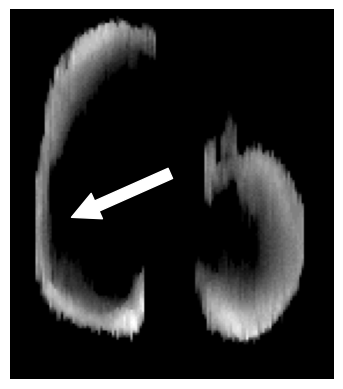

In [108]:
# display entire mask
cropy = (55, 215)
cropz = (10, 150)

f, ax = plt.subplots()
ax.imshow(np.sum(gt_numpy,axis=0)[cropy[0]:cropy[1],cropz[0]:cropz[1]], cmap = 'gray')

# add arrow
arrow = mpatches.FancyArrowPatch((x_tail, y_tail), (x_head, y_head),
                                 mutation_scale=40, color="w")
ax.add_patch(arrow)
ax.axis('off')
plt.savefig(f"test{idx}_gt", bbox_inches="tight", dpi=1000)
plt.show()

In [109]:
# READ IN CORRESPONDING PREDICTION FROM TEST PREDICTOIN FOLDERS
sam1_folder = 'frozen_final_test_preds'
sam2_folder = 'end2end_bce_test_preds'
unet_folder = 'final_unet_aug_test_preds'

sam1_seg_path = os.path.join(DATA_DIR, sam1_folder, test_paths[idx] + '.npy')
sam2_seg_path = os.path.join(DATA_DIR, sam2_folder, test_paths[idx] + '.npy')
unet_seg_path = os.path.join(DATA_DIR, unet_folder, test_paths[idx] + '.npy')

sam1_mask = np.load(sam1_seg_path)
sam2_mask = np.load(sam2_seg_path)
unet_mask = np.load(unet_seg_path)

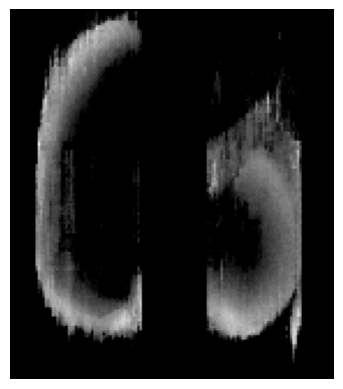

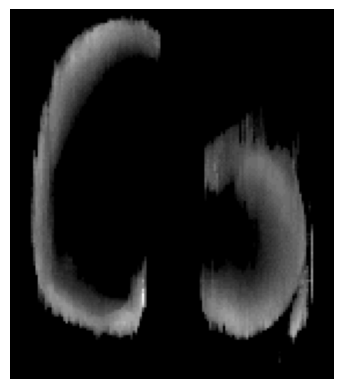

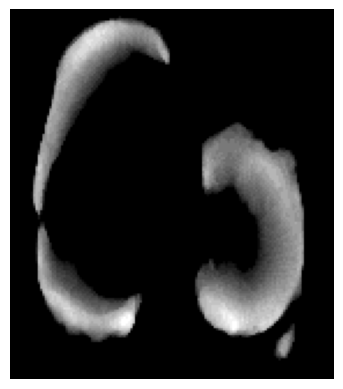

In [110]:
# display 3 different models' mask predictions
plt.imshow(np.sum(sam1_mask,axis=0)[cropy[0]:cropy[1],cropz[0]:cropz[1]], cmap = 'gray')
plt.axis('off')
plt.savefig(f"test{idx}_sam1", bbox_inches="tight", dpi=1000)
plt.show()
plt.imshow(np.sum(sam2_mask,axis=0)[cropy[0]:cropy[1],cropz[0]:cropz[1]], cmap = 'gray')
plt.axis('off')
plt.savefig(f"test{idx}_sam2", bbox_inches="tight", dpi=1000)
plt.show()
plt.imshow(np.sum(unet_mask,axis=0)[cropy[0]:cropy[1],cropz[0]:cropz[1]], cmap = 'gray')
plt.axis('off')
plt.savefig(f"test{idx}_unet", bbox_inches="tight", dpi=1000)
plt.show()

In [ ]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Load up best U-Net
PATH = '../models/unet_with_aug_bs4_60e_best_E.pth'
state_dict = torch.load(PATH, map_location=device)

In [ ]:
# Sometimes, the model dictionary keys contain 'module.' prefix which we don't want
remove_prefix = True

if remove_prefix:
    remove_prefix = 'module.'
    state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

model = UNet3D(1,1,16)
model.load_state_dict(state_dict)
model.eval();

In [ ]:
im = im.to(device)
model.to(device)
out = model(im)

In [ ]:
out_numpy = out.squeeze(0).squeeze(0).detach().cpu().numpy()

In [ ]:
out_numpy.shape

(200, 256, 160)

In [ ]:
# apply threshold
thresh = 0.5
out_numpy = (out_numpy>0.5).astype(np.uint8)

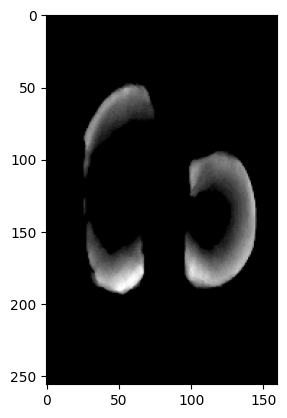

In [ ]:
# display entire prediction
plt.imshow(np.sum(out_numpy,axis=0), cmap = 'gray')
plt.show()

In [ ]:
connectivity = 26
out_labels, out_num_labels = cc3d.connected_components(out_numpy, connectivity = connectivity, return_N=True)

In [ ]:
np.sum(out_numpy)

58140

In [ ]:
np.sum(gt_numpy)

57987.0

In [ ]:
# Display the number of detected components
print("Number of connected components:", out_num_labels)

Number of connected components: 4


In [ ]:
# Stats and the like
(out_stats := cc3d.statistics(out_labels))

{'voxel_counts': array([8133860,   32059,   15303,   10704,      74], dtype=uint32),
 'bounding_boxes': [(slice(0, 200, None),
   slice(0, 256, None),
   slice(0, 160, None)),
  (slice(95, 141, None), slice(94, 190, None), slice(96, 146, None)),
  (slice(100, 134, None), slice(143, 194, None), slice(28, 68, None)),
  (slice(114, 137, None), slice(48, 114, None), slice(26, 75, None)),
  (slice(130, 137, None), slice(127, 139, None), slice(26, 28, None))],
 'centroids': array([[ 99.32824243, 127.40686906,  79.43173881],
        [125.50544309, 147.28207368, 122.00658162],
        [118.58851206, 177.11599033,  49.69672613],
        [124.6107997 ,  68.05511958,  47.03802317],
        [132.55405405, 132.16216216,  26.27027027]])}

In [ ]:
stats

{'voxel_counts': array([8134013,   30416,   17066,   10505], dtype=uint32),
 'bounding_boxes': [(slice(0, 200, None),
   slice(0, 256, None),
   slice(0, 160, None)),
  (slice(95, 142, None), slice(93, 188, None), slice(96, 145, None)),
  (slice(97, 136, None), slice(143, 196, None), slice(23, 67, None)),
  (slice(115, 138, None), slice(48, 106, None), slice(23, 70, None))],
 'centroids': array([[ 99.32698165, 127.40394784,  79.45150776],
        [126.48635587, 145.84800763, 123.13078643],
        [118.23942341, 176.52595805,  46.02537208],
        [124.88881485,  69.10299857,  45.10118991]])}

In [ ]:
# Extract binary masks for the different objects
out_objs = []
for i in range(out_num_labels):
    out_objs.append((out_labels == i+1).astype(np.uint8))

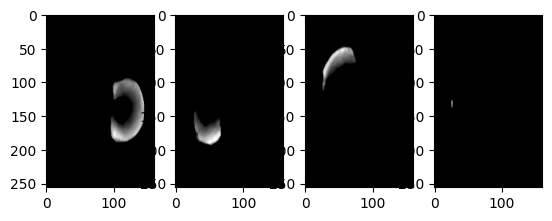

In [ ]:
# display each component
import matplotlib.pyplot as plt
plt.subplots(1, len(out_objs))
for obj_num in range(len(out_objs)):
  plt.subplot(1, len(out_objs), obj_num+1)
  plt.imshow(np.sum(out_objs[obj_num],axis=0), cmap = 'gray')
plt.show()

In [ ]:
from metrics import bce_dice_loss, dice_coefficient, batch_dice_coeff
dice_coefficient(torch.tensor(out_numpy), torch.tensor(gt_numpy))

0.8729925155639648

In [ ]:
# Compare to segment anything (See if SAM is better at recognising that the lateral meniscus is in two pieces)

In [ ]:
# Load in SAM
sam_checkpoint = "../models/sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [ ]:
# Create model
model = my_SAM(
    image_encoder=copy.deepcopy(sam.image_encoder),
    prompt_encoder=copy.deepcopy(sam.prompt_encoder),
    mask_decoder=copy.deepcopy(sam.mask_decoder),
)

In [ ]:
# Load trained weights in
state_dict = torch.load("../models/sam_e2e_final_best_E.pth")

In [ ]:
# Sometimes, the model dictionary keys contain 'module.' prefix which we don't want
remove_prefix = True

if remove_prefix:
    remove_prefix = 'module.'
    state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model.to(device)
model.eval();

In [ ]:
# images to check out: train set 25, 99, 109; test set 5
# im, gt = train_val_dataset[idx]
# im = im.unsqueeze(0)
# gt = gt.unsqueeze(0)

In [ ]:
sam_pred = get_3d_sam_pred(model, im)

In [ ]:
# display entire prediction
plt.imshow(np.sum(sam_pred,axis=0), cmap = 'gray')
plt.show()

In [ ]:
dice_coefficient(torch.tensor(sam_pred), torch.tensor(gt_numpy))

In [ ]:
connectivity = 26
sam_labels, sam_num_labels = cc3d.connected_components(sam_pred, connectivity = connectivity, return_N=True)

In [ ]:
sam_num_labels

In [ ]:
# Extract binary masks for the different objects
objs = []
for i in range(sam_num_labels):
    objs.append((sam_labels == i+1).astype(np.uint8))

In [ ]:
# display each component
import matplotlib.pyplot as plt
#plt.subplots(1, len(objs), figsize=(500,20))
for obj_num in range(len(objs)):
  #plt.subplot(1, len(objs), obj_num+1)
  plt.imshow(np.sum(objs[obj_num],axis=0), cmap = 'gray')
  plt.show()